# IBM's Qiskit Global Summer School 2023
## Lab 5 - Error Mitigation with Qiskit Runtime:

- In this lab, we'll explore a few of the error mitigation options available through IBM's Qiskit Runtime. Specifically, we'll define a simple observable and initial state and use the Estimator primitive to measure the expectation value. Using noisy simulations, we'll explore the effect of different error mitigation strategies.

## Setup

We'll define a simple Heisenberg Hamiltonian model to use as an example. We'll also construct a simple state preparation circuit.

In [1]:
# import the quantum circuit and the quantum register
# from the IBM's Qiskit library
from qiskit import QuantumCircuit, QuantumRegister

# import the Sparse Pauli operator from
# the IBM's Qiskit quantum information module
from qiskit.quantum_info import SparsePauliOp


# defome the function to generate a Sparse Pauli operator
# for the Heisenberg's Hamiltonian
def heisenberg_hamiltonian(
    length: int, jx: float = 1.0, jy: float = 0.0, jz: float = 0.0
) -> SparsePauliOp:
  
    # create an empty list for the terms
    terms = []
    
    
    # for each index ranged for the number of qubits on
    # the Heisenberg's Hamiltonian
    for i in range( ( length - 1 ) ):
        
        # if it is pretended to append a XX operator term to
        # the Heisenberg's Hamiltonian operator
        if jx:
            
            # append a XX operator term to
            # the Heisenberg's Hamiltonian operator
            terms.append( ( "XX", [i, i + 1], jx ) )
        
        # if it is pretended to append a YY operator term to
        # the Heisenberg's Hamiltonian operator
        if jy:
            
            # append a YY operator term to
            # the Heisenberg's Hamiltonian operator
            terms.append( ( "YY", [i, i + 1], jy ) )
    
        # if it is pretended to append a ZZ operator term to
        # the Heisenberg's Hamiltonian operator
        if jz:
            
            # append a ZZ operator term to
            # the Heisenberg's Hamiltonian operator
            terms.append( ( "ZZ", [i, i + 1], jz ) )
    
    
    # return the Sparse Pauli operator
    # for the Heisenberg's Hamiltonian
    return SparsePauliOp.from_sparse_list(terms, num_qubits=length)


# define a function to generate the quantum circuit for the state preparation
def state_prep_circuit( num_qubits: int, layers: int = 1 ) -> QuantumCircuit:
 
    # create a quantum register with the number of qubits pretended
    qubits = QuantumRegister(num_qubits, name="q")

    # create a quantum circuit with the quantum register defined before
    circuit = QuantumCircuit(qubits)
    
    # apply a Hadamard gate to
    # the quantum circuit, on all the qubits
    circuit.h(qubits)
    
    
    # for each layer of the quantum circuit
    for _ in range(layers):
    
        # for each 2n-th qubit
        for i in range(0, ( num_qubits - 1 ), 2):
            
            # apply a CX/CNOT gate to
            # the quantum circuit,
            # with control on the current qubit
            # and target on the next qubit
            circuit.cx( qubits[i], qubits[ ( i + 1 ) ] )
        
        # apply a RY (Rotation-Y) gate to
        # the quantum circuit, on the 1st qubit,
        # with the theta angle equal to 0.1
        # on all the qubits
        circuit.ry( 0.1, qubits )
    
        # for each (2n + 1)-th qubit
        for i in range(1, ( num_qubits - 1 ), 2):
            
            # apply a CX/CNOT gate to
            # the quantum circuit,
            # with control on the current qubit
            # and target on the next qubit
            circuit.cx( qubits[i], qubits[ ( i + 1 ) ] )
        
        # apply a RY (Rotation-Y) gate to
        # the quantum circuit, on the 1st qubit,
        # with the theta angle equal to 0.1
        # on all the qubits
        circuit.ry(0.1, qubits)
    
    
    # return the quantum circuit for the state preparation
    return circuit

SparsePauliOp(['IIIXX', 'IIIYY', 'IIXXI', 'IIYYI', 'IXXII', 'IYYII', 'XXIII', 'YYIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


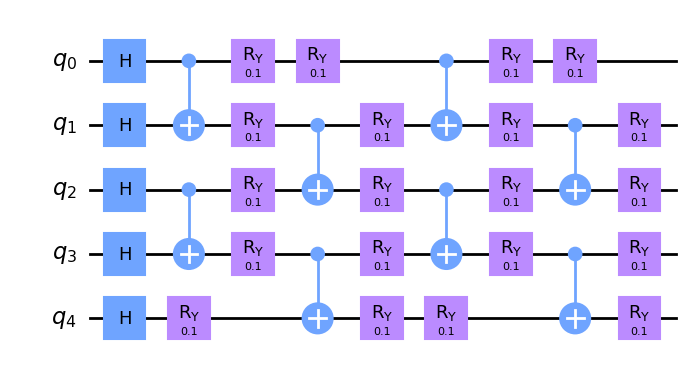

In [2]:
# define the number of qubits for
# the Heisenberg's Hamiltonian operator and
# for the state preparation quantum circuit
length = 5


# create the Heisenberg's Hamiltonian operator
# for the number of qubits defined before
hamiltonian = heisenberg_hamiltonian( length, 1.0, 1.0 )

# create the state preparation quantum circuit
# for the number of qubits defined before
circuit = state_prep_circuit( length, layers=2 )


# print the Heisenberg's Hamiltonian operator
print(hamiltonian)

# draw the quantum circuit implementing
# a state preparation
circuit.draw("mpl")

## Calculate exact expectation value (energy)

First, we'll calculate the exact expectation value using a local simulator implementation of the Estimator primitive. The expectation value of a Hamiltonian is also referred to as "energy."

In [3]:
# import estimator from IBM's Qiskit
# Aer primitives module
from qiskit_aer.primitives import Estimator


# create an Estimator object with approximation
estimator = Estimator( approximation=True )


# create a job for the quantum circuit implementing
# the Heisenberg's Hamiltonian, running the Estimator
job = estimator.run( circuit, hamiltonian, shots=None )

# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()

# retrieve the exact expectation value (energy)
# from the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
exact_value = result.values[0]


# print the exact expectation value (energy)
# from the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
print( f"Exact energy: {exact_value}" )

Exact energy: 4.290938711029713


## Run noisy simulation through Qiskit Runtime

Next, we'll initialize the IBM's Qiskit Runtime service and switch to using its Estimator primitive, backed by a simulator that can handle noise. Even though our circuit acts on 5 qubits, we'll initialize a simulator with 6 qubits in order to later demonstrate the potential effects of qubit choice.

First, let's setup the IBM's Qiskit Runtime Service.

In [4]:
# import the IBM's Qiskit Runtime Service
# from the Qiskit IBM's Runtime
from qiskit_ibm_runtime import QiskitRuntimeService


# define the hub for the IBM's Qiskit
# Runtime Service
hub = "ibm-q-internal"

# define the group for the IBM's Qiskit
# Runtime Service
group = "deployed"

# define the project for the IBM's Qiskit
# Runtime Service
project = "default"


# create an IBM's Qiskit Runtime Service
service = QiskitRuntimeService(instance=f"{hub}/{group}/{project}")

/opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:422: UserWarning: Default hub/group/project ibm-q-internal/deployed/default not found for the account and is ignored.
  warnings.warn(


Next, let's configure the quantum simulation.

In [5]:
# import the estimator, options and session
# for quantum simulations from the Qiskit IBM Runtime module
from qiskit_ibm_runtime import Estimator, Options, Session

# import the coupling map from
# the IBM's Qiskit Transpiler module
from qiskit.transpiler import CouplingMap


# define the backend to run the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime
backend = service.get_backend("simulator_statevector")


# set the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime
simulator = {
    "basis_gates": ["id", "rz", "sx", "cx", "reset"],
    "coupling_map": list(CouplingMap.from_line(length + 1)),
}


# define the number of shots for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime
shots = 10000

### (Noiseless) Simulation with no noise

First, we'll run the (noiseless) simulation with no noise.

In [6]:
# import the built-in math module
import math


# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# with a resilience level of 0 (zero)
options = Options(
    simulator=simulator,
    resilience_level=0,
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )


# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variance from the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
variance = result.metadata[0]["variance"]

# compute the standard deviation of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
std = math.sqrt( variance / shots )


# print the statistics for the estimated energy,
# the energy error, the variance, and the standard error
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.2648
Energy error: 0.02613871102971288
Variance: 4.47627104
Standard error: 0.021157199814720286


### Readout error

Next, let's run a simulation with readout error.

<div class="alert alert-block alert-success"> Ex. 1 - Build a quantum noise model for a global readout error. </div>

#### Exercise 1

In this exercise, you'll construct a noise model that has modest readout error on all qubits except for the first qubit, which will have really bad readout error.

Specifically, construct a noise model with the following properties:
- For the first qubit (qubit 0):
  - A readout of 1 has a 50% probability of being erroneously read as 0.
  - A readout of 0 has a 20% probability of being erroneously read as 1.
- For the rest of the qubits:
  - A readout of 1 has a 5% probability of being erroneously read as 0.
  - A readout of 0 has a 2% probability of being erroneously read as 1.

You may find it helpful to consult the following resources:
  - https://qiskit.org/ecosystem/aer/apidocs/aer_noise.html
  - https://qiskit.org/documentation/stable/0.24/tutorials/simulators/3_building_noise_models.html

In [7]:
# import the noise model and the readout error
# from the IBM's Qiskit Aer Noise module
from qiskit_aer.noise import NoiseModel, ReadoutError


# create a noise model
noise_model = NoiseModel()


##### your code here #####

# create the measurement miss-assignments and
# correct measurement probabilities

# create the measurement miss-assignment
# probabilities for the 1st qubit,
# for the erroneous measurement outcomes
qubit0_p0_given1 = 0.2
qubit0_p1_given0 = 0.5

# create the correct measurement
# probabilities for the 1st qubit
qubit0_p0_given0 = (1 - qubit0_p0_given1)
qubit0_p1_given1 = (1 - qubit0_p1_given0)


# create the measurement miss-assignment
# probabilities for the remaining qubits k_i,
# for the erroneous measurement outcomes
qubitk_p0_given1 = 0.02
qubitk_p1_given0 = 0.05

# create the correct measurement
# probabilities for the remaining qubits k_i
qubitk_p0_given0 = (1 - qubitk_p0_given1)
qubitk_p1_given1 = (1 - qubitk_p1_given0)


# create the readout error objects

# create a readout error for the 1st qubit
readout_error_qubit0 = ReadoutError( [ [ qubit0_p0_given0, qubit0_p0_given1 ],
                                       [ qubit0_p1_given0, qubit0_p1_given1 ] ] )

# ceeate a readout error for the remaining qubits k_i
readout_error_qubitk = ReadoutError( [ [ qubitk_p0_given0, qubitk_p0_given1 ],
                                       [ qubitk_p1_given0, qubitk_p1_given1 ] ] )


# add a readout error to the noise model for the 1st qubit
noise_model.add_readout_error( readout_error_qubit0, [0] )


# for each of the remaining qubits k_i
# note: recall that even though our circuit acts on 5 qubits,
#       we will initialize a simulator with 6 qubits in order to
#       later demonstrate the potential effects of qubit choice
for k in range( 1, ( length + 1 ) ):
    
    # add a readout error to the noise model
    # for the remaining qubits k_i
    noise_model.add_readout_error( readout_error_qubitk, [k] )

    
# print the noise model created before
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5]
  Specific qubit errors: [('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,))]


In [8]:
# submit your answer

# import the grader for the exercise 1 of the lab 5
from qc_grader.challenges.qgss_2023 import grade_lab5_ex1

# grade the exercise 1 of the lab 5
grade_lab5_ex1(noise_model)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


First, let's try running the simulation without doing anything to mitigate the readout error. We'll explicitly set `resilience_level = 0` to ensure that no error mitigation is applied by the Runtime service. To illustrate the effect of a poor choice of qubits, we'll explicitly specify an initial layout that includes qubit 0.

In [9]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# considering the noise model defined before,
# and a resilience level of 0 (zero)
options = Options(
    simulator=dict( noise_model=noise_model, **simulator ),
    resilience_level=0,
    transpilation=dict( initial_layout=list( range(length) ) ),
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )
    

# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variance from the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
variance = result.metadata[0]["variance"]

# compute the standard deviation of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
std = math.sqrt( variance / shots )


# print the statistics for the estimated energy,
# the energy error, the variance, and the standard error
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 3.5192
Energy error: 0.7717387110297129
Variance: 5.39996816
Standard error: 0.023237831568371434


The error we get is pretty large. To improve things, let's pick a qubit layout that avoids qubit 0.

In [10]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# considering the noise model defined before,
# and a resilience level of 0 (zero),
# but this time, with a layout where
# the 1st qubit is not considered
options = Options(
    simulator=dict( noise_model=noise_model, **simulator ),
    resilience_level=0,
    transpilation=dict( initial_layout=list( range(1, ( length + 1 ) ) ) ),
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )


# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variance from the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
variance = result.metadata[0]["variance"]

# compute the standard deviation of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
std = math.sqrt( variance / shots )


# print the statistics for the estimated energy,
# the energy error, the variance, and the standard error
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 3.9545999999999997
Energy error: 0.33633871102971336
Variance: 4.96369676
Standard error: 0.02227935537667102


The error is smaller now, but still significant. Let's now enable readout error mitigation by setting `resilience_level = 1`.

In [11]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# considering the noise model defined before,
# and a resilience level of 1 (one),
# but this time, with a layout where
# the 1st qubit is not considered
options = Options(
    simulator=dict( noise_model=noise_model, **simulator ),
    resilience_level=1,
    transpilation=dict( initial_layout=list( range( 1, ( length + 1 ) ) ) ),
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )


# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variance from the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
variance = result.metadata[0]["variance"]

# compute the standard deviation of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
std = math.sqrt( variance / shots )


# print the statistics for the estimated energy,
# the energy error, the variance, and the standard error
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.283775783303248
Energy error: 0.007162927726464652
Variance: 7.094957540982811
Standard error: 0.026636361502620456


Now, the effect of readout error has been almost completely mitigated! This mitigation did not come for free. In particular,
- To perform readout error mitigation, the Runtime service has to run additional calibration circuits, so the overall running time may be longer.
- The variance of the estimator has increased, leading to a larger standard error of the mean. As a consequence, a larger number of shots needs to be specified in order to achieve a given standard error.

Typically, these costs are relatively small, so it is almost always worthwhile to enable readout error mitigation.

<div class="alert alert-block alert-success"> Ex. 2 - Determine the required number of shots that keep the same standard error, if the readout error mitigation increases the variance by a factor of 2. </div>

#### Exercise 2

Suppose that turning on readout error mitigation increases the variance of your estimator by a factor of 2. If you originally ran your experiment with 10,000 shots, how many shots should you now use to achieve the same standard error of the mean?

In [12]:
# define the variable for
# the new number of shots
new_shots: int


##### your code here #####

# define the new number of shots
new_shots = 20000

In [13]:
# submit your answer

# import the grader for the exercise 2 of the lab 5
from qc_grader.challenges.qgss_2023 import grade_lab5_ex2

# grade the exercise 2 of the lab 5
grade_lab5_ex2(new_shots)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Depolarizing error and zero-noise extrapolation

In this section, we will see how depolarizing error can be mitigated using zero-noise extrapolation. Because the zero-noise extrapolation feature of IBM's Qiskit Runtime is still in beta, it currently has a few limitations. In particular, as of the time of this writing, the zero-noise extrapolation feature does not mitigate readout error. Therefore, in the examples below, we will remove readout error from our noise model.

<div class="alert alert-block alert-success"> Ex. 3 - Build a quantum noise model for a two-qubit depolarizing error after each $CNOT$/$CX$ gate. </div>

#### Exercise 3

Construct a noise model that adds two-qubit depolarizing error after each CNOT gate, such that the error channel maps the input quantum state to the completely mixed state with 1% probability.

In [14]:
# import the noise model and the depolarizing error
# from the IBM's Qiskit Aer Noise module
from qiskit_aer.noise import depolarizing_error


# creata a noise model
noise_model = NoiseModel()


##### your code here #####

# create the depolarizaation probability
depolarization_prob = 0.01


# create the depolarization error objects

# create a two-qubit depolarization error for two qubits
depolarizing_error_two_quits = depolarizing_error( depolarization_prob, 2 )


# add the two-qubit depolarization error after each CNOT/CX gate
noise_model.add_all_qubit_quantum_error( depolarizing_error_two_quits, ['cx'] )


# print the noise model created before
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx']
  All-qubits errors: ['cx']


In [15]:
# submit your answer

# import the grader for the exercise 3 of the lab 5
from qc_grader.challenges.qgss_2023 import grade_lab5_ex3

# grade the exercise 3 of the lab 5
grade_lab5_ex3(noise_model)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Let's run the estimator with `resilience_level = 1`, which turns on readout error mitigation. Because our noise model doesn't include readout error mitigation, we don't expect this to help.

In [16]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# with a resilience level of 1 (one)
options = Options(
    simulator=dict( noise_model=noise_model, **simulator ),
    resilience_level=1,
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )


# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variance from the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
variance = result.metadata[0]["variance"]

# compute the standard deviation of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
std = math.sqrt( variance / shots )


# print the statistics for the estimated energy,
# the energy error, the variance, and the standard error
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.1152
Energy error: 0.17573871102971328
Variance: 4.8137908
Standard error: 0.021940352777473745


As expected, the error we get is pretty significant.

Now, let's turn on zero-noise extrapolation by setting `resilience_level = 2`.

In [17]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# with a resilience level of 2 (two)
options = Options(
    simulator=dict( noise_model=noise_model, **simulator ),
    resilience_level=2,
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )
    

# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variances of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian,
# applying Zero-Noise Extrapolation with Noise Amplification
variances = result.metadata[0]["zne"]["noise_amplification"]["variance"]


# print the statistics for the estimated energy,
# the energy error, and the variances
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variances: {variances}")

Estimated energy: 4.214833333333336
Energy error: 0.07610537769637737
Variances: [4.805336319999999, 5.47060428, 5.8813592]


Now, the effect of depolarizing noise has been almost completely mitigated! Note that instead of getting a single variance value for the estimator, we are now returned a list of variances, one for each data point measured for the extrapolation. In a future version of IBM's Qiskit Runtime, these variances will also be extrapolated to return a single variance for the final estimator.

<div class="alert alert-block alert-success"> Ex. 4 (ungraded) - Build other quantum noise models to be mitigated with zero-noise extrapolation. </div>

#### Exercise 4 (ungraded)

Besides depolarizing error, what other kinds of noise can be mitigated by zero-noise extrapolation? Test your proposals by constructing other noise models, and then simulating them with and without zero-noise extrapolation.

Let's define the noise model for the bit flip error.

In [18]:
# import Pauli error from
# the IBM's Qiskit Aer Noise module
from qiskit_aer.noise import pauli_error


# create a noise model
noise_model = NoiseModel()


##### your code here #####

# create the Pauli error probability
pauli_error_prob = 0.1


# create the Pauli error objects

# create a bit flip error for a qubit
bit_flip_error = pauli_error( [ ( "X", pauli_error_prob ),
                                ( "I", ( 1 - pauli_error_prob ) ) ] )


# add a bit flip error for a qubit,
# after each Pauli-X, Pauli-Y, Pauli-Z, and Hadamard gate
noise_model.add_all_qubit_quantum_error( bit_flip_error, ["x", "y", "z", "h"] )


# print the noise model created before
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x', 'y', 'z']
  Instructions with noise: ['y', 'h', 'x', 'z']
  All-qubits errors: ['x', 'y', 'z', 'h']


Let's run the estimator with `resilience_level = 0` to ensure that no error mitigation is applied by the Runtime service.

In [19]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# with a resilience level of 0 (zero)
options = Options(
    simulator=dict( noise_model=noise_model, **simulator ),
    resilience_level=0,
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )
    

# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variance from the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
variance = result.metadata[0]["variance"]

# compute the standard deviation of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
std = math.sqrt( variance / shots )


# print the statistics for the estimated energy,
# the energy error, the variance, and the standard error
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.272399999999999
Energy error: 0.018538711029713717
Variance: 4.4645373600000005
Standard error: 0.021129451862270353


Let's run the estimator with `resilience_level = 1`, which turns on readout error mitigation.

In [20]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# with a resilience level of 1 (one)
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=1,
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )
    

# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variance from the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
variance = result.metadata[0]["variance"]

# compute the standard deviation of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
std = math.sqrt( variance / shots )


# print the statistics for the estimated energy,
# the energy error, the variance, and the standard error
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.274824595814142
Energy error: 0.016114115215571267
Variance: 8.56100274406175
Standard error: 0.029259191280795422


Now, let's turn on zero-noise extrapolation by setting `resilience_level = 2`.

In [21]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# with a resilience level of 2 (two)
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=2,
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )


# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variances of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian,
# applying Zero-Noise Extrapolation with Noise Amplification
variances = result.metadata[0]["zne"]["noise_amplification"]["variance"]


# print the statistics for the estimated energy,
# the energy error, and the variances
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variances: {variances}")

Estimated energy: 4.290283333333335
Energy error: 0.0006553776963782454
Variances: [4.46540188, 4.48098736, 4.47434272]


Let's define the noise model for the phase flip error.

In [22]:
# import Pauli error from
# the IBM's Qiskit Aer Noise module
from qiskit_aer.noise import pauli_error


# create a noise model
noise_model = NoiseModel()


##### your code here #####

# create the Pauli error probability
pauli_error_prob = 0.1


# create the Pauli error objects

# create a phase flip error for a qubit
phase_flip_error = pauli_error( [ ( "Z", pauli_error_prob ),
                                  ( "I", ( 1 - pauli_error_prob ) ) ] )


# add a phase flip error for a qubit,
# after each Pauli-X, Pauli-Y, Pauli-Z, and Hadamard gate
noise_model.add_all_qubit_quantum_error( phase_flip_error, ["x", "y", "z", "h"] )


# print the noise model created before
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x', 'y', 'z']
  Instructions with noise: ['y', 'h', 'x', 'z']
  All-qubits errors: ['x', 'y', 'z', 'h']


Let's run the estimator with `resilience_level = 0` to ensure that no error mitigation is applied by the Runtime service.

In [23]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# with a resilience level of 0 (zero)
options = Options(
    simulator=dict( noise_model=noise_model, **simulator ),
    resilience_level=0,
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )
    

# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variance from the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
variance = result.metadata[0]["variance"]

# compute the standard deviation of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
std = math.sqrt( variance / shots )


# print the statistics for the estimated energy,
# the energy error, the variance, and the standard error
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.3016
Energy error: 0.01066128897028662
Variance: 4.44668384
Standard error: 0.021087161591831178


Let's run the estimator with `resilience_level = 1`, which turns on readout error mitigation.

In [24]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# with a resilience level of 1 (one)
options = Options(
    simulator=dict( noise_model=noise_model, **simulator ),
    resilience_level=1,
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )
    

# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variance from the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
variance = result.metadata[0]["variance"]

# compute the standard deviation of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
std = math.sqrt( variance / shots )


# print the statistics for the estimated energy,
# the energy error, the variance, and the standard error
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.293
Energy error: 0.002061288970287123
Variance: 4.476032119999999
Standard error: 0.021156635176700474


Now, let's turn on zero-noise extrapolation by setting `resilience_level = 2`.

In [25]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# with a resilience level of 2 (two)
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=2,
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )


# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variances of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian,
# applying Zero-Noise Extrapolation with Noise Amplification
variances = result.metadata[0]["zne"]["noise_amplification"]["variance"]


# print the statistics for the estimated energy,
# the energy error, and the variances
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variances: {variances}")

Estimated energy: 4.2693
Energy error: 0.02163871102971271
Variances: [4.46518532, 4.45294392, 4.443589960000001]


Let's define the noise model for the reset error.

In [26]:
# import Reset error from
# the IBM's Qiskit Aer Noise module
from qiskit_aer.noise import reset_error


# create a noise model
noise_model = NoiseModel()


##### your code here #####

# create the Reset error probabilities
reset_0_prob = 0.2
reset_1_prob = 0.33


# create the Reset error objects

# create a Reset error for a qubit
reset_0_1_error = reset_error( reset_0_prob, reset_1_prob )


# add a Reset error for a qubit,
# after each Pauli-X, Pauli-Y, Pauli-Z, and Hadamard gate
noise_model.add_all_qubit_quantum_error( reset_0_1_error, ["x", "y", "z", "h"] )


# print the noise model created before
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx', 'x', 'y', 'z']
  Instructions with noise: ['y', 'h', 'x', 'z']
  All-qubits errors: ['x', 'y', 'z', 'h']


Let's run the estimator with `resilience_level = 0` to ensure that no error mitigation is applied by the Runtime service.

In [27]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# with a resilience level of 0 (zero)
options = Options(
    simulator=dict( noise_model=noise_model, **simulator ),
    resilience_level=0,
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )
    

# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variance from the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
variance = result.metadata[0]["variance"]

# compute the standard deviation of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
std = math.sqrt( variance / shots )


# print the statistics for the estimated energy,
# the energy error, the variance, and the standard error
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.321
Energy error: 0.030061288970286704
Variance: 4.4240206
Standard error: 0.021033355890109406


Let's run the estimator with `resilience_level = 1`, which turns on readout error mitigation.

In [28]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# with a resilience level of 1 (one)
options = Options(
    simulator=dict( noise_model=noise_model, **simulator ),
    resilience_level=1,
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )
    

# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variance from the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
variance = result.metadata[0]["variance"]

# compute the standard deviation of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
std = math.sqrt( variance / shots )


# print the statistics for the estimated energy,
# the energy error, the variance, and the standard error
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.190858233514689
Energy error: 0.10008047751502414
Variance: 15.77436433799761
Standard error: 0.03971695398441025


Now, let's turn on zero-noise extrapolation by setting `resilience_level = 2`.

In [29]:
# define the options for the quantum simulation
# to run in the backend, using the IBM's Qiskit Runtime,
# with a resilience level of 2 (two)
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=2,
)


# within the context of a session of the IBM's Qiskit Runtime 
with Session( service=service, backend=backend ):
    
    # create an estimator object with the options defined before
    estimator = Estimator(options=options)
    
    # create a job for the quantum circuit implementing
    # the Heisenberg's Hamiltonian, running the Estimator
    job = estimator.run( circuit, hamiltonian, shots=shots )


# retrieve the results of the job ran by
# the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
result = job.result()


# retrieve the values of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian
experiment_value = result.values[0]

# compute the error as the distance between
# the experiment value and the exact value
error = abs(experiment_value - exact_value)

# retrieve the variances of the results of
# the job ran by the Estimator created before,
# that was ran on the quantum circuit
# implementing the Heisenberg's Hamiltonian,
# applying Zero-Noise Extrapolation with Noise Amplification
variances = result.metadata[0]["zne"]["noise_amplification"]["variance"]


# print the statistics for the estimated energy,
# the energy error, and the variances
print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variances: {variances}")

Estimated energy: 4.3398833333333355
Energy error: 0.04894462230362251
Variances: [4.433444, 4.4332847200000005, 4.4658270799999995]


Conclusion: The bit flip error noise model seems to benefit from error mitigation with zero-noise extrapolation.

In [30]:
# import the IBM's Qiskit Jupyter Tools
import qiskit.tools.jupyter

# show the table of the IBM's Qiskit version
%qiskit_version_table

Congratulations! You've completed Lab 5 of the Global Summer School!! 🎉

Made with ❤ by Rúben André Barreiro (and adapted from IBM Quantum).